# <b>Room-Temp. NV Experimental Control Notebook</b>

<b>Introduction:</b>  
This Jupyter Lab notebook controls the room-temp. NV experimental setup on the second optical bench in B00 within the Lukin Group. This experiment contains a laser scanning confocal microscope to study 2D materials. The confocal microscope uses a 100$x$ objective and a fiber-coupled excitation laser at 635 $n$m. The experiment is controlled by a National Instruments (NI) data-acquisition card, specifically the NI-cDAQ series (model 9174). This DAQ contains two cards/modules: 1. the NI-9402 module which contains four bi-directional digital input/output (I/O) channels -also featuring programmable internal clocks for counting. And 2. the NI-9263 module which contains four analog output channels (-10 V to +10 V).

This notebook functions as the experimental control software for this room-temp NV measurement setup. This notebook implements the [CoDeS](https://qcodes.github.io/https://qcodes.github.io/) data-acquisition framework written by the Copenhagen/Delft/Sydney/Microsoft quantum computing consortium. QCoDeS is a Python-based framework that uses imported functions and databses to carry about measurements. Additional files are imported within the "Imports" section; including the [NI-DAQmx](https://nidaqmx-python.readthedocs.io/en/latest/https://nidaqmx-python.readthedocs.io/en/latest/) framework which uses Python C-type wrappers to communicate with the NI DAQ card. The basic use of this notebook is as follows: "instruments" such as the NI-9402 and NI-9263 module (or mode added at a later date) are created using the internal QCoDeS methods. From here, a "database", "station", and an "experiment" are created also following the QCoDeS context. Then diferent measurements can be written and run using the reviously initialized instruments -populating a database for analysis and plotting. This notebook is meant to be continually added to. Measurements will be run, parameters will be changed, and each iteration (experimental run) is carried out within the "Measurement" section below; then analized and visualized within the "Analysis" section.

<b>Helful notes when learning this control framework for the first time:</b>
1. The NI-cDAQ card (chasis) is called (this can be changed using the NI-MAX software when the NI-DAQ card is connect to this computer) "cDAQ1". Additional info. about the cDAQ device and its inserted modules (as of 081522 only ni_9402 and ni_9263) can be viewed in the NI-MAX software. This software opens automatically when the cDAQ device is connected to <em>this</em> computer
2. The first module inserted into the cDAQ card (the NI-9402 module) is called "mod1". This naming pattern follows the available slots within the cDAQ chasis (there are four available slots)
3. The second module in the cDAQ chasis (the NI-9263 module) is called "mod2" following in suit
4. The QCoDeS "experiment_name" is "room_temp_NV_exp_control_experimentroom_temp_NV_exp_control_experiment"
5. The QCoDeS "database_name" is "room_temp_NV_exp_control_databaseroom_temp_NV_exp_control_database"
6. The QCoDeS "station_name" is "room_temp_NV_exp_control_stationroom_temp_NV_exp_control_station"

Notebook timeline:
071022 $\rightarrow$ 083122  

Initial author: Miles D. Ackerman (undergraduate during summer of 2022)

## Preliminaries

___

The below cells in this section contain code referenced before any other setup. This is the preamble for this notebook allowing ease of editing for referenced files that are called in this notebook.

### Auto-reload for editing imported files (packages)

This short series of commands does not need to be run if starting from the top of this notebook. It will automatically reference the most recently saved edited files imported below.

In [2]:
# auto-reload commands
%load_ext autoreload
%autoreload 2

### Closing created instruments (modules)

Use if starting from the top of the notebook only. Otherwise, already initialized instruments will be lost and MUST be re-created before any measurement can be made.

In [2]:
# TODO: fix both below code cells for closing instruments
# goal: close instruments only if open to prevent accidentally closing instruments

# try:
#     ni_9402.close, ni_9263.close()
# except NameError:
#     print("already clsoed")

In [4]:
# closing the ni_9402 module (first slot within the NI-cDAQ)
ni_9402.close()

NameError: name 'ni_9402' is not defined

In [5]:
# closing the ni_9263 module (second slot within the NI-cDAQ)
ni_9263.close()

NameError: name 'ni_9263' is not defined

## Importing  required modules

___

This below cell contains all of the referenced imports (files/modules) used in this experimental control notebook.

In [2]:
# overall imports
import numpy as np
import qcodes as qc
import nidaqmx
import os
from time import sleep
from tqdm.notebook import trange, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

# qcodes dataset imports
from qcodes.dataset import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)

# import qcodes contrib_drivers NI package (all)
from qcodes_contrib_drivers.drivers.NationalInstruments.DAQ import *
from qcodes_contrib_drivers.drivers.NationalInstruments.class_file import *

# import mulit-D scanning module (from QCoDeS)
from qcodes.utils.dataset.doNd import (
    dond,
    LinSweep,
    do1d
)

# import plotting module (from QCoDeS)
from qcodes.dataset.plotting import plot_dataset

# import interactive widget from QCoDeS
from qcodes.interactive_widget import experiments_widget

# other imports
%matplotlib inline
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.instrument.parameter import Parameter
from qcodes.dataset import initialise_or_create_database_at
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import load_or_create_experiment
from qcodes.dataset.plotting import plot_dataset
from qcodes import Station, initialise_or_create_database_at, \
    load_or_create_experiment, Measurement
import IPython.lib.backgroundjobs as bg
from plottr.apps import inspectr
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.loops import Loop
from qcodes.plots.pyqtgraph import QtPlot

In [ ]:
# TODO: some of the above imports are not currently used in this eperiment control (as of 081522)

In [ ]:
# TODO: QCoDeS logging?
# https://qcodes.github.io/Qcodes/examples/logging/logging_example.html

# include QCoDeS logging above?

## Creating instruments

___

The below cells initialize each instrument (hardware cards inserted into the cDAQ) to be used for measurement.

### Creating the ni_9402 instrument (slot one in the cDAQ card)

This module's info. can be found at: [https://www.ni.com/en-us/support/model.ni-9402.htmlhttps://www.ni.com/en-us/support/model.ni-9402.html](NI-9402). This module functions as a counter based on an internal clock within the module. The first part of the below cell defines all of the avilable parameters for creating a counter assigned to this module. The counter requires the use of two of the four available channels on this cDAQ card. One channel is for input (from the APD on the optical bench), and one channel for the hardware-timed clock to "run" the counter. Currently (as of 081522) only one counter (analog input) channel can be created at a time. In order to change this functionality, the source code for this contributed drivers package must be edited.

In [7]:
# def the parameters of the instrument
ni_9402_device_name = "cDAQ1Mod1"
ni_9402_counter_channel = "cDAQ1Mod1/ctr0"
ni_9402_clock_channel = "cDAQ1Mod1/ctr1"
ni_9402_source_channel = "/cDAQ1/Ctr1InternalOutput"
ni_9402_sampling_rate = 1000
ni_9402_samples_per_channel = 1
ni_9402_duty_cycle = 0.5
ni_9402_integration_time = 0.3
ni_9402_timeout = 0.01

# creating the instrument for mod1
ni_9402 = Counter("ni_9402_module", ni_9402_device_name, ni_9402_counter_channel,
    ni_9402_clock_channel, ni_9402_source_channel, ni_9402_sampling_rate,
    ni_9402_samples_per_channel, ni_9402_duty_cycle,
    ni_9402_integration_time, ni_9402_timeout
    )

In [ ]:
# TODO: allow for multiple counter input channels (can more than one counter input channel be liked to the same hardware-timed referene clock?)
# This should function as the NI-9263 ao_channels initializations statement -a list of available channels to reference instead of one defined one as above

### creating ni_9263 instrument (slot two in the cDAQ chasis)

This module's info can be found at: [https://www.ni.com/en-us/support/model.ni-9263.htmlhttps://www.ni.com/en-us/support/model.ni-9263.html](NI-9263). This moduel is used for programmable digital output. This functionality is largely used for controlling the servo motors on the ThorLab's galvo (by writing a sequence of voltages to them -see "Galvo scan" for more info.). Here, all available digital output channels are created in one line: `ni_9263_ao_channels` where a single channel can be accessed at a time.

In [8]:
# naming the instrument
ni_9263_device_name = "cDAQ1Mod2"

# dictionary of analog output channels
ni_9263_ao_channels = {f'{ni_9263_device_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
ni_9263 = DAQAnalogOutputs("ni_9263_module", ni_9263_device_name, ni_9263_ao_channels)

## Getting instrument snapshots

___

This verifies required parameters are setup properly verifies required parameters are setup properly

### ni_9402 module (cDAQ1 slot one) snapshot

In [9]:
# get ni_9402 snapshot
ni_9402.print_readable_snapshot()

ni_9402_module:
	parameter                 value
--------------------------------------------------------------------------------
IDN                        :	None 
integrateavg               :	None (#)
read_counter_cdaq1mod1ctr0 :	None (#)


### ni_9263 (cDAQ1 slot two) module snapshot

In [10]:
# get ni_9263 snapshot
ni_9263.print_readable_snapshot()

ni_9263_module:
	parameter           value
--------------------------------------------------------------------------------
IDN                  :	None 
voltage_cdaq1mod2ao0 :	None (V)
voltage_cdaq1mod2ao1 :	None (V)
voltage_cdaq1mod2ao2 :	None (V)
voltage_cdaq1mod2ao3 :	None (V)


## Creating a station

___

This follows the QCoDeS framework to create a station for running measurements. Previously initializied instruments can be (are) added to the station in order to be referenced later using other functions.

In [22]:
# create the station at the designated name
room_temp_NV_exp_control_station = qc.Station()

### Adding the ni_9402 instrument to the station

In [12]:
# add ni_9402_module to station
room_temp_NV_exp_control_station.add_component(ni_9402)

#TODO: fix the IDN error here

[ni_9402_module(Counter)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 640, in get_idn
    idstr = self.ask('*IDN?')
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 961, in ask
    raise e
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 954, in ask
    answer = self.ask_raw(cmd)
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 974, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument Counter has not defined an ask method', "asking '*IDN?' to <Counter: ni_9402_module>")
[ni_9402_module(Counter)] Snapshot: Could not update parameter: read_counter_cdaq1mod1ctr0
[ni_9402_module(Counter)] Snapshot: Could not update parameter: integrateavg


'ni_9402_module'

### Adding the ni_9263 instrument to the station

In [13]:
# add ni_9263 to station
room_temp_NV_exp_control_station.add_component(ni_9263)

#TODO: fix the IDN error here

[ni_9263_module(DAQAnalogOutputs)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 640, in get_idn
    idstr = self.ask('*IDN?')
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 961, in ask
    raise e
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 954, in ask
    answer = self.ask_raw(cmd)
  File "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\instrument\base.py", line 974, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument DAQAnalogOutputs has not defined an ask method', "asking '*IDN?' to <DAQAnalogOutputs: ni_9263_module>")


'ni_9263_module'

### Getting the whole station snapshot

This cell outputs all of the accessible info. corresponding to the user-defined instruments.

In [20]:
# calling to view station snapshot
_=room_temp_NV_exp_control_station.snapshot()# can addd "_ = " at beginning to supress long output

## Creating a databaase

___

This is where all measurement and recorded data is written to. This data can be accessed in a number of ways but first must have a storage place designated. Multiple databases can be created and accessed

### Initialize the database for later use

In [25]:
# create the database. "initialise" also functions to load a previously created database. Multiple databases can be created
# as of 081522 only one database has been created (used for writing this notebook and testing)
initialise_or_create_database_at("~/room_temp_NV_exp_control_database.db")

### Confirming the database location on THIS computer

In [26]:
# testing database location on THIS computer
qc.config.core.db_location

'~/room_temp_NV_exp_control_database.db'

## Creating an experiment

___

This is the last cell following the notebook outline from QCoDeS. This "experiment" is used for running measurements later along with the instruments, station, and database

### Initilize the experiment

In [7]:
# setting up experiment name and experiment data
room_temp_NV_exp_control_experiment = load_or_create_experiment(
    experiment_name = "room_temp_NV_exp_control_experiment",
    sample_name = "room_temp_NV_exp_control_experiment_data"
)

## Measurement

___

Below this cells starts the measurement section for this experiment. This is where new measurements will be created and run. Analysis of measurements (including plotting of data can be carried out in the last section of this notebook -"Analysis"). Taking measurements follow this proces: ADD INFO HERE. The different types of measurements are numbered as written below. When analyzing data from one of these measurements, refer to the corresponding section in "Analysis".

### Reading from the chosen counter channel (Measurement)

This measurement section soley reads data from the chosen counter channel (this counter channel was initialized when the instrument, NI-9402 was created above in "Creating Instruments"). Within this section are code cells for reading a single sample from the counter and for reading a finite number of samples from the channel.

#### 1. Reading a single sample from the chosen counter channel (Measurement)

Read a single sample from the chosen counter (this returns a result based on the pre-set parameters when the instrument was created). No parameters for this measurement can be changed here.

Notes: Can this measurement can be implemented using doNd func? See [this link here](https://qcodes.github.io/Qcodes/examples/DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.html)

In [262]:
# setup the measurement
counter_single_sample_meas = Measurement(
    exp = room_temp_NV_exp_control_experiment,
    station = room_temp_NV_exp_control_station,
    name = "counter_single_sample_meas"
    )

# register a parameter to the above measurement
counter_single_sample_meas.register_parameter(ni_9402.read_counter_cdaq1mod1ctr0)

# run the measurement (read the counter value)
with counter_single_sample_meas.run() as datasaver:
    result_test = ni_9402.read_counter_cdaq1mod1ctr0()

    # saving the single read counter value to a user-named dataset
    counter_single_sample_dataset = datasaver.dataset

# temp line -delete
print(result_test)

Starting experimental run with id: 130. 
4.0


#### 2. Reading a finite number of smaples from the chosen counter channel (Measurement)

This measurement reads a finite number of samples from the ni_9402 module counter channel (the selected channel was defined when the instrument was created in "Instruments"). The parameters defined when the ni_9402 insturment was created still apply here (e.g. sampling rate). Only the number of samples to acquire from the counter can be changed here

Notes: This measurement can be implemented using doNd func. See [this link here](https://qcodes.github.io/Qcodes/examples/DataSet/Using_doNd_functions_in_comparison_to_Measurement_context_manager_for_performing_measurements.html)

Starting experimental run with id: 220. 


counter read progress:   0%|          | 0/100 [00:00<?, ?it/s]

([<AxesSubplot:title={'center':'Run #220, Experiment room_temp_NV_exp_control_experiment (room_temp_NV_exp_control_experiment_data)'}, xlabel='Elapsed time (s)', ylabel='Counter (#)'>],
 [None])

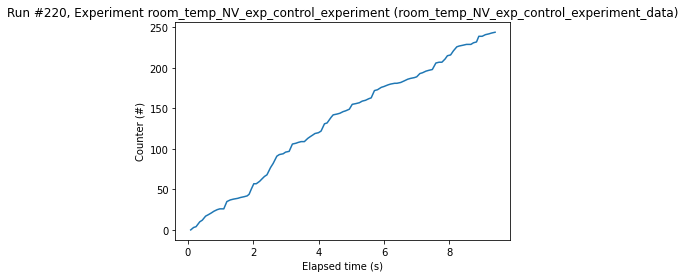

In [407]:
# setup pre-parameters for the finite measurement
counter_value_to_read = ni_9402.read_counter_cdaq1mod1ctr0
time = ElapsedTimeParameter("time")

# user-defined variable for the measurement
num_counter_values_to_read = 100

# setup the measurement
counter_finite_samples_meas = Measurement(
    exp = room_temp_NV_exp_control_experiment,
    station = room_temp_NV_exp_control_station,
    name = "counter_finite_samples_meas"
    )

# registering defined parameters to the measurement (counter_finite_samples_meas)
counter_finite_samples_meas.register_parameter(time)
counter_finite_samples_meas.register_parameter(counter_values, setpoints = [time])

# loop to read finite number of values from counter
with counter_finite_samples_meas.run() as datasaver:
    
    # before loop statements
    counter_values_list = 0
    time.reset_clock()
    
    # measurement loop
    for i in trange(num_counter_values_to_read, desc = "counter read progress"): # use tqdm for progress bar
        counter_values_list += counter_value_to_read()
        current_time = time()
        datasaver.add_result((counter_value_to_read, counter_values_list), (time, current_time))

# save to user-defined/named dataset for later viewing
counter_finite_samples_dataset = datasaver.dataset

# temp line DELETE later
plot_dataset(counter_finite_samples_dataset)

### Piezo control (Measurement [?])

This section controls the PI (Physik Instrumente) E-665.XR LVPZT-Amplifier/Servo controller for the piezo-mounted objective within the confocal setup.

Notes:
1. Move this to a new "Control" section?
2. From the E-665 manual: "The nominal input voltage range is 0 to +10 V for a 0 to 100 V output voltage swing."
3. Can run a BNC cable for the "sensor monitor" socket on the E-665 box. This would allow checking of the voltage supplied to the piezo. Could: write a "Checks" section for this fnc; and galvo x and galvo y voltages?
4. Would "Control" section and "Checks" section be the same thing?
5. Implement a "Piezo sweep" script as written in b26_toolkit?
6. 

#### 1. testing the instrument can be controlled

Move this to a new "Control" section?

In [182]:
# test. Delete later
ni_9263.voltage_cdaq1mod2ao2(0)

In [181]:
# this will be driven by a BNC output from channel 2 on the ni_9263 instrument. This BNC is connected to the "CONTROL IN" BNC socket on the box

sleep(10)

for i in range(5):
    ni_9263.voltage_cdaq1mod2ao2(0)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(1)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(2)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(3)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(4)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(5)
    sleep(2)
    ni_9263.voltage_cdaq1mod2ao2(6)
    sleep(2)

### Galvo scanning (Measurement)

This section contains the measurement code cells for galvo scanning. Are there different types?

In [561]:
# resetting x-mirror, y-mirror, and obj z-piezo to 0.0

scan_galvo.voltage_cdaq1mod2ao0(0.0)
scan_galvo.voltage_cdaq1mod2ao1(0.0)
scan_galvo.voltage_cdaq1mod2ao2(0.0)

In [558]:
# spectrum taking to find diamond
# high-intensity point selection try #1

scan_galvo.voltage_cdaq1mod2ao0(-0.18)
scan_galvo.voltage_cdaq1mod2ao1(-0.02)
scan_galvo.voltage_cdaq1mod2ao2(9.0)

Scanning progress:   2%|2         | 1/50 [00:00<?, ?it/s]

SCANNING INFO:
grid size = 50, counter read time per pixel: 0.050000 s, x-mirror step voltage 0.012000 V, y-mirror step voltage: 0.012000 V, initial driving voltage for x-mirror -0.300000 V, initial driving voltage for y-mirror: -0.300000 V, 
complete cell run time (minus printing info. and plotting): 0:02:05.129686


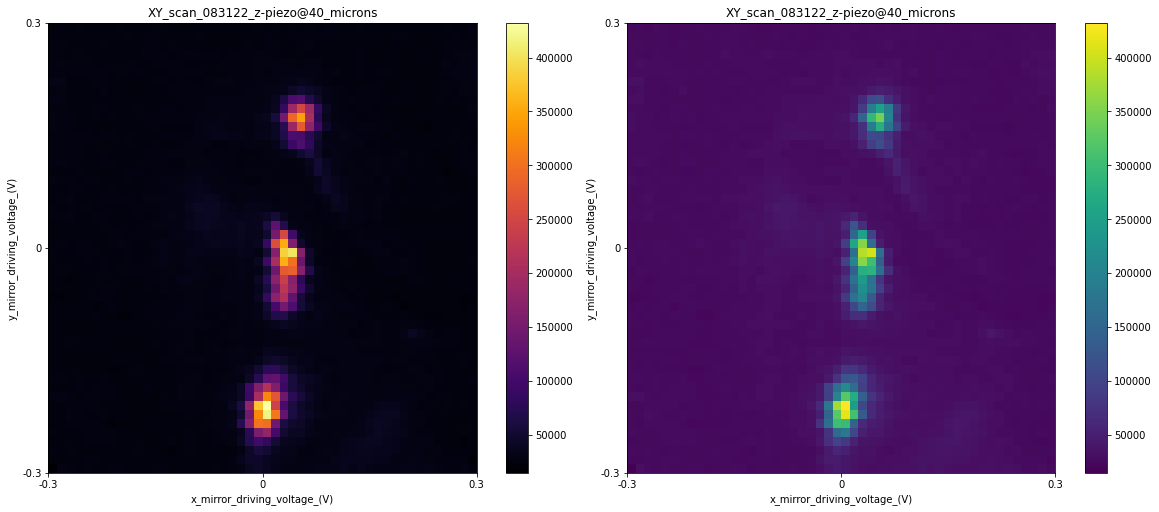

In [97]:
"""
XY scan @ specified obj z-piezo height

This cell runs a generic X and Y only scan. It currently creates and then populates a user defined size numpy array according to a set counter acquisition time and a motor
step voltage setting. Additionally, the initial driving voltage for the X and Y motors can be set according to the desired scanning range. An adjust factor is in place to
maintain the current scanning window while only adjusting the resolution of the produced data/image. This scan resets the objective's z-piezo to 0.0 microns / 0.0 V. This
setting can be changed if scanning at a different z-height is desired. This scanning program runs in a snake pattern, it scan the first row left to right, moves up one row, 
then scans right to left and continues. Alternatives would be scanning left to right, and resetting the position of the laser on the next higher row and scanning again left 
to right OR scanning in a "circular" patter either CW or CCW from outside to inside or inside to outside. The chosen method was picked for simplicity of understanding. The 
scanning loops are present within NI-DAQmx tasks to speed up the program. Starting and stopping a NI-DAQmx task repeatedly slows down the program dramatically. So, the 
counter and hardware clock task are started once, then the scanning program is run, and then the counter and clock tasks are closed -un-reserving the hardware resources. 
This cell uses the "DAQAnalogOutputs" function from a written class file at:
C:/Users/lukin2dmaterials/miniconda3/envs/qcodes/Lib/site-packages/qcodes_contrib_drivers/drivers/NationalInstruments/class_file. Slashes are reversed to run

Last modified/ran: 083122
"""

# TODO: make this record a QCoDeS measurement
# TODO: allow grid_size_z and grid_size_y to change indep. Currently makes an error if do not match
# TODO: fix plotting scale and add labels
# TODO: update printed SCANNING INFO

complete_cell_run_time_start = datetime.datetime.now()                                                                               # optional timing line

scan_galvo.close()                                                                                             # note: must be omitted when running for the first time

################################################################################## card 2 (AO) ########################################################################

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables #####################################################################

################### setting variales and array ####################

# counter read time:
scan_counter_acquisition_time = 0.05                                                                               # note a reading time <0.05 s is likely too short

# def
grid_size = 50
grid_size_x = grid_size_y = grid_size

# def the initial driving voltage for the x-mirror
initial_x_driving_voltage = -0.30
# def the initial driving voltage for the y-mirror
initial_y_driving_voltage = -0.30

z_piezo_set_voltage = 4.0

# setup parameter for the program to use based on defined variables
x_driving_voltage_to_change = initial_x_driving_voltage
y_driving_voltage_to_change = initial_y_driving_voltage

# set desired end mirror voltages
desired_end_x_mirror_voltage = 0.3 # desired_end_x_mirror_voltage = 0.0
desired_end_y_mirror_voltage = 0.3 # desired_end_y_mirror_voltage = 0.0 # 0.34325

# def the internal stepping voltages based on user-entered settings above
x_drive_voltage_step = ((np.absolute(initial_x_driving_voltage)) + (desired_end_x_mirror_voltage)) / grid_size_x
y_drive_voltage_step = ((np.absolute(initial_y_driving_voltage)) + (desired_end_y_mirror_voltage)) / grid_size_y

# create dataset to populate
data_array = np.zeros((grid_size_x, grid_size_y))

# initializing variables to store read counter info.
output_value = 0
counter_value = 0

################### setting up QCoDeS measurement #####################

galvo_meas_082422 = Measurement(name = "test_name", exp = room_temp_NV_exp_control_experiment)
# galvo_meas_082422.register_parameter(scan_galvo.voltage_cdaq1mod2ao0)
# galvo_meas_082422.register_parameter(scan_galvo.voltage_cdaq1mod2ao1)
# galvo_meas_082422.register_parameter(task1.read, setpoints = (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao1))

################### resetting position of mirrors ####################

scan_galvo.voltage_cdaq1mod2ao0(initial_x_driving_voltage) # this is for the x-mirror

scan_galvo.voltage_cdaq1mod2ao1(initial_y_driving_voltage) # this is for the y-mirror

scan_galvo.voltage_cdaq1mod2ao2(z_piezo_set_voltage) # setting the z_piezo to z_piezo_set_voltage microns

########################################################### setting up NI-DAQmx tasks and channels for counting ########################################################

with nidaqmx.Task() as task1, nidaqmx.Task() as counter_output_task: # this defines 2 NI-DAQmx tasks (one for the counter and one for the counter's clock)

    # adding dig pulse train chan
    counter_output_task.co_channels.add_co_pulse_chan_freq(
        counter = "cDAQ1Mod1/ctr1",
        name_to_assign_to_channel = "",
        units = FrequencyUnits.HZ,
        idle_state = nidaqmx.constants.Level.LOW,
        initial_delay = 0.0,
        freq = 1000,
        duty_cycle = 0.5
        )

    # cfg implict timing
    counter_output_task.timing.cfg_implicit_timing(
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )

    # adding count egdes chan
    task1.ci_channels.add_ci_count_edges_chan(
        counter = "cDAQ1Mod1/ctr0",
        name_to_assign_to_channel = "",
        edge = Edge.RISING,
        initial_count = 0,
        count_direction = CountDirection.COUNT_UP
        )

    # cfg sample clk timing
    task1.timing.cfg_samp_clk_timing(
        rate = 1000,
        source = "/cDAQ1/Ctr1InternalOutput",
        active_edge = Edge.RISING,
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )
    
    counter_output_task.start() # this starts the counter NI-DAQmx task
    task1.start() # this starts the hardware-based internal clock NI-DAQmx task
    
    # with galvo_meas_082422.run() as datasaver: # this sets up the QCoDeS datasaver in order to save read data as a QCoDeS measurement
        
######################################################################## X and Y scanning #########################################################################

    for f in trange(grid_size_y, desc = "Scanning progress", initial = 1, colour = "Green"): # this loops for rows (y)

        for k in range(grid_size_x): # this loops for columns (x)

            ################## important section #################

            for my_var_not_named_i in range(int(scan_counter_acquisition_time * 1000)): # this reads/lets the counter accumulate for the set time and returns value
                counter_value = task1.read()
                output_value += counter_value

            if f % 2 != 0: # this loop populates the created data_array (the if else strucuture is present bc of the snaking scanning pattern)
                data_array[f][((-k) + 1)] = (output_value - np.sum(data_array)) # add counter result to data array                           # saving (082422)
                output_value == 0
                counter_value == 0
            else:
                if f == 0 and k == 0:
                    data_array[0][0] = output_value # add counter result to data array                                                      # saving
                else:
                    data_array[f][k] = (output_value - np.sum(data_array)) # add counter result to data array                               # saving (082422)
            output_value = 0
            counter_value = 0

            # datasaver.add_result(
            #     (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao0()),
            #     (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1()),
            #     (task1.read, task1.read())
            #     )

            ############# end important section ############

            if f % 2 == 0: # this loop adjusts for sweeping back and forth along each alternating row
                if k < (grid_size_x - 1):
                    x_driving_voltage_to_change += x_drive_voltage_step # increment drive voltage forwards
                    scan_galvo.voltage_cdaq1mod2ao0(x_driving_voltage_to_change) # step x motor
                else:
                    break
            else:
                if k < (grid_size_x - 1):
                    x_driving_voltage_to_change -= x_drive_voltage_step # increment drive voltage backwards
                    scan_galvo.voltage_cdaq1mod2ao0(x_driving_voltage_to_change) # step x motor
                else:
                    break

        if f < (grid_size_y - 1): # this loop prevents from scanning an upper undesired row
            y_driving_voltage_to_change += y_drive_voltage_step # increment drive voltage
            scan_galvo.voltage_cdaq1mod2ao1(y_driving_voltage_to_change) # step y motor
        else:
            break

    counter_output_task.stop() # this stops the counter NI-DAQmx task - free-ing the reserved cDAQ card resources
    task1.stop() # this stops the hardware-based internal clock NI-DAQmx task - free-ing the reserved cDAQ card resources

################################################################### visualizing scan info. and data #####################################################################

####### printing out scanning and timing info ########
print("SCANNING INFO:")
complete_cell_run_time_end = datetime.datetime.now()                                                                                 # optional timing line
complete_cell_run_time = complete_cell_run_time_end - complete_cell_run_time_start                                                     # optional timing line
print("grid size = %s, " % (grid_size), end = "")
print("counter read time per pixel: %f s, " % scan_counter_acquisition_time, end = "")
print("x-mirror step voltage %f V, y-mirror step voltage: %f V, " % (x_drive_voltage_step, y_drive_voltage_step), end = "")
print("initial driving voltage for x-mirror %f V, initial driving voltage for y-mirror: %f V, " % (initial_x_driving_voltage, initial_y_driving_voltage))
print("complete cell run time (minus printing info. and plotting): %s" % complete_cell_run_time)
# print("\n" + str(data_array))                                                # note the manual data_array must explicitly be saved for user viewing or analysis
# np.save("title_1.npy", data_array)                                                                                  # optional for saving data_array

########## plotting populated data array using MatPlotLib ########
fig, axs = plt.subplots(1, 2, figsize = (16, 7), layout = "constrained")

plot_1 = axs[0].pcolormesh(data_array, cmap = "inferno")
fig.colorbar(plot_1, ax = axs[0])
axs[0].set_xlabel("x_mirror_driving_voltage_(V)")
axs[0].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_x_driving_voltage, int((initial_x_driving_voltage + desired_end_x_mirror_voltage) / 2), desired_end_x_mirror_voltage])
axs[0].set_ylabel("y_mirror_driving_voltage_(V)")
axs[0].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_y_driving_voltage, int((initial_y_driving_voltage + desired_end_y_mirror_voltage) / 2), desired_end_y_mirror_voltage])
axs[0].set_title("XY_scan_083122_z-piezo@%d_microns" % int((z_piezo_set_voltage * 10)))

plot_2 = axs[1].pcolormesh(data_array)
fig.colorbar(plot_2, ax = axs[1])
axs[1].set_xlabel("x_mirror_driving_voltage_(V)")
axs[1].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_x_driving_voltage, int((initial_x_driving_voltage + desired_end_x_mirror_voltage) / 2), desired_end_x_mirror_voltage])
axs[1].set_ylabel("y_mirror_driving_voltage_(V)")
axs[1].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_y_driving_voltage, int((initial_y_driving_voltage + desired_end_y_mirror_voltage) / 2), desired_end_y_mirror_voltage])
axs[1].set_title("XY_scan_083122_z-piezo@%d_microns" % int((z_piezo_set_voltage * 10)));

# plt.savefig("title_2.png", dpi = 3000)                                                                        # optional for saving high-res MPL plot image

In [19]:
np.save("083022_first_scan_for_single_NVs.npy", data_array)

Scanning progress:   2%|2         | 1/50 [00:00<?, ?it/s]

SCANNING INFO:
grid size = 50, counter read time per pixel: 0.050000 s, y-mirror step voltage 0.008000 V, initial x-mirror driving voltage -0.050000 V, initial y-mirror driving voltage: -0.300000 V, 
complete cell run time (minus printing info. and plotting): 0:02:05.135571


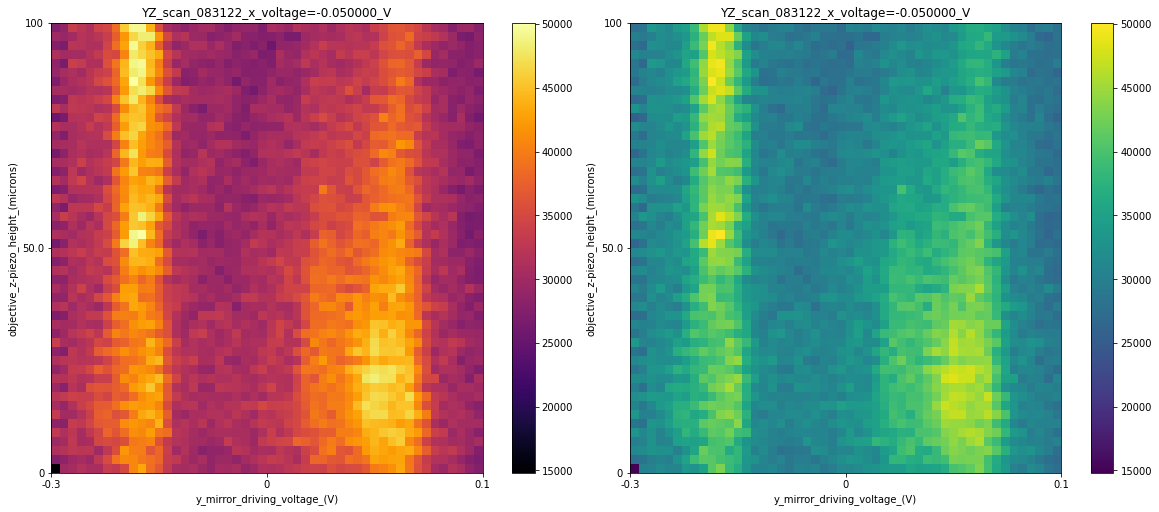

In [96]:
"""
YZ scanning: Fixing x, changing y

last modified/run: 083122

This cell runs a generic X and Y only scan. It currently creates and then populates a user defined size numpy array according to a set counter acquisition time and a motor
step voltage setting. Additionally, the initial driving voltage for the X and Y motors can be set according to the desired scanning range. An adjust factor is in place to
maintain the current scanning window while only adjusting the resolution of the produced data/image. This scan resets the objective's z-piezo to 0.0 microns / 0.0 V. This
setting can be changed if scanning at a different z-height is desired. This scanning program runs in a snake pattern, it scan the first row left to right, moves up one row, 
then scans right to left and continues. Alternatives would be scanning left to right, and resetting the position of the laser on the next higher row and scanning again left 
to right OR scanning in a "circular" patter either CW or CCW from outside to inside or inside to outside. The chosen method was picked for simplicity of understanding. The 
scanning loops are present within NI-DAQmx tasks to speed up the program. Starting and stopping a NI-DAQmx task repeatedly slows down the program dramatically. So, the 
counter and hardware clock task are started once, then the scanning program is run, and then the counter and clock tasks are closed -un-reserving the hardware resources. 
This cell uses the "DAQAnalogOutputs" function from a written class file at:
C:/Users/lukin2dmaterials/miniconda3/envs/qcodes/Lib/site-packages/qcodes_contrib_drivers/drivers/NationalInstruments/class_file. Slashes are reversed to run
"""

# TODO: make this record a QCoDeS measurement
# TODO: grid size here likely should not be required to be square
# TODO: fix printing statements at end of program -specific to xz scanning
# TODO: implement yz scanning?
# TODO: fix plotting scale and add labels
# TODO: allow grid_size_z and grid_size_y to change indep. Currently makes an error if do not match

complete_cell_run_time_start = datetime.datetime.now()                                                                               # optional timing line

scan_galvo.close()                                                                                             # note: must be omitted when running for the first time

################################################################################## card 2 (AO) ########################################################################

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables #####################################################################

################### setting variales and array ####################

# counter read time:
scan_counter_acquisition_time = 0.05                                                                               # note a reading time <0.05 s is likely too short

# def
grid_size = 50

# def the initial driving voltage for the x-mirror
initial_x_driving_voltage = -0.05

# def the initial driving voltage for the y-mirror
initial_y_driving_voltage = -0.3
#
initial_z_piezo_driving_voltage = 0.0

# setup parameter for the program to use based on defined variables
y_driving_voltage_to_change = initial_y_driving_voltage
z_piezo_driving_voltage_to_change = initial_z_piezo_driving_voltage

# set desired end mirror voltages
desired_end_y_mirror_voltage = 0.1
desired_end_z_piezo_voltage = 10

# def the internal stepping voltages based on user-entered settings above
y_drive_voltage_step = ((np.absolute(initial_y_driving_voltage)) + (desired_end_y_mirror_voltage)) / grid_size
z_piezo_drive_voltage_step = (initial_z_piezo_driving_voltage + (desired_end_z_piezo_voltage)) / grid_size

# create dataset to populate
data_array = np.zeros((grid_size, grid_size))

# initializing variables to store read counter info.
output_value = 0
counter_value = 0

################### resetting position of mirrors ####################

scan_galvo.voltage_cdaq1mod2ao0(initial_x_driving_voltage) # this is for fixing the x-mirror at defined setting (voltage)

scan_galvo.voltage_cdaq1mod2ao1(initial_y_driving_voltage) # this is for setting the initial x voltage

scan_galvo.voltage_cdaq1mod2ao2(initial_z_piezo_driving_voltage) # starting z-piezo at 0.0 V (0 microns); this variable will increase during scanning

########################################################### setting up NI-DAQmx tasks and channels for counting ########################################################

with nidaqmx.Task() as task1, nidaqmx.Task() as counter_output_task: # this defines 2 NI-DAQmx tasks (one for the counter and one for the counter's clock)

    # adding dig pulse train chan
    counter_output_task.co_channels.add_co_pulse_chan_freq(
        counter = "cDAQ1Mod1/ctr1",
        name_to_assign_to_channel = "",
        units = FrequencyUnits.HZ,
        idle_state = nidaqmx.constants.Level.LOW,
        initial_delay = 0.0,
        freq = 1000,
        duty_cycle = 0.5
        )

    # cfg implict timing
    counter_output_task.timing.cfg_implicit_timing(
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )

    # adding count egdes chan
    task1.ci_channels.add_ci_count_edges_chan(
        counter = "cDAQ1Mod1/ctr0",
        name_to_assign_to_channel = "",
        edge = Edge.RISING,
        initial_count = 0,
        count_direction = CountDirection.COUNT_UP
        )

    # cfg sample clk timing
    task1.timing.cfg_samp_clk_timing(
        rate = 1000,
        source = "/cDAQ1/Ctr1InternalOutput",
        active_edge = Edge.RISING,
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )
    
    counter_output_task.start() # this starts the counter NI-DAQmx task
    task1.start() # this starts the hardware-based internal clock NI-DAQmx task
            
####################################################################### x and z scanning #########################################################################

    for f in trange(grid_size, desc = "Scanning progress", initial = 1, colour = "Green"): # this loops for stacks in z

        for k in range(grid_size): # this loops for columns (varying y voltage/setting)

            ################## important section #################

            for my_var_not_named_i in range(int(scan_counter_acquisition_time * 1000)): # this reads/lets the counter accumulate for the set time and returns value
                counter_value = task1.read()
                output_value += counter_value

            if f % 2 != 0: # this loop populates the created data_array (the if else strucuture is present bc of the snaking scanning pattern)
                data_array[f][((-k) + 1)] = (output_value - np.sum(data_array)) # add counter result to data array                           # saving (082422)
                output_value == 0
                counter_value == 0
            else:
                if f == 0 and k == 0:
                    data_array[0][0] = output_value # add counter result to data array                                                      # saving
                else:
                    data_array[f][k] = (output_value - np.sum(data_array)) # add counter result to data array                               # saving (082422)
            output_value = 0
            counter_value = 0

            ############# end important section ############

            if f % 2 == 0: # this loop adjusts for sweeping back and forth along each alternating row
                if k < (grid_size - 1):
                    y_driving_voltage_to_change += y_drive_voltage_step # increment y mirro drive voltage forwards
                    scan_galvo.voltage_cdaq1mod2ao1(y_driving_voltage_to_change) # step y mirror
                else:
                    break
            else:
                if k < (grid_size - 1):
                    y_driving_voltage_to_change -= y_drive_voltage_step # increment y mirror drive voltage backwards
                    scan_galvo.voltage_cdaq1mod2ao1(y_driving_voltage_to_change) # step y mirror
                else:
                    break

        if f < (grid_size - 1): # this loop
            z_piezo_driving_voltage_to_change += z_piezo_drive_voltage_step # increment drive voltage
            scan_galvo.voltage_cdaq1mod2ao2(z_piezo_driving_voltage_to_change) # step z
        else:
            break

    counter_output_task.stop() # this stops the counter NI-DAQmx task - free-ing the reserved cDAQ card resources
    task1.stop() # this stops the hardware-based internal clock NI-DAQmx task - free-ing the reserved cDAQ card resources

################################################################### visualizing scan info. and data #####################################################################

####### printing out scanning and timing info ########
print("SCANNING INFO:")
complete_cell_run_time_end = datetime.datetime.now()                                                                                 # optional timing line
complete_cell_run_time = complete_cell_run_time_end - complete_cell_run_time_start                                                     # optional timing line
print("grid size = %s, " % (grid_size), end = "")
print("counter read time per pixel: %f s, " % scan_counter_acquisition_time, end = "")
print("y-mirror step voltage %f V, " % y_drive_voltage_step, end = "")
print("initial x-mirror driving voltage %f V, initial y-mirror driving voltage: %f V, " % (initial_x_driving_voltage, initial_y_driving_voltage))
print("complete cell run time (minus printing info. and plotting): %s" % complete_cell_run_time)
# print("\n" + str(data_array))                                                # note the manual data_array must explicitly be saved for user viewing or analysis
# np.save("title_1.npy", data_array)                                                                                  # optional for saving data_array

########## plotting populated data array using MatPlotLib ########
fig, axs = plt.subplots(1, 2, figsize = (16, 7), layout = "constrained")

plot_1 = axs[0].pcolormesh(data_array, cmap = "inferno")
fig.colorbar(plot_1, ax = axs[0])
axs[0].set_xlabel("y_mirror_driving_voltage_(V)")
axs[0].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_y_driving_voltage, int((initial_y_driving_voltage + desired_end_y_mirror_voltage) / 2), desired_end_y_mirror_voltage])
axs[0].set_ylabel("objective_z-piezo_height_(microns)")
axs[0].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [int(initial_z_piezo_driving_voltage * 10), (int(initial_z_piezo_driving_voltage * 10) + int(desired_end_z_piezo_voltage * 10)) / 2, int(desired_end_z_piezo_voltage * 10)])
axs[0].set_title("YZ_scan_083122_x_voltage=%f_V" % initial_x_driving_voltage)

plot_2 = axs[1].pcolormesh(data_array)
fig.colorbar(plot_2, ax = axs[1])
axs[1].set_xlabel("y_mirror_driving_voltage_(V)")
axs[1].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_y_driving_voltage, int((initial_y_driving_voltage + desired_end_y_mirror_voltage) / 2), desired_end_y_mirror_voltage])
axs[1].set_ylabel("objective_z-piezo_height_(microns)")
axs[1].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [int(initial_z_piezo_driving_voltage * 10), (int(initial_z_piezo_driving_voltage * 10) + int(desired_end_z_piezo_voltage * 10)) / 2, int(desired_end_z_piezo_voltage * 10)])
axs[1].set_title("YZ_scan_083122_x_voltage=%f_V" % initial_x_driving_voltage);

# plt.savefig("title_2.png", dpi = 3000)                                                                        # optional for saving high-res MPL plot image

Scanning progress:   2%|2         | 1/50 [00:00<?, ?it/s]

SCANNING INFO:
grid size = 50, counter read time per pixel: 0.050000 s, initial x-mirror driving voltage -0.150000 V, end x-mirror driving voltage: 0.050000 V, y-mirror set throughout driving voltage -0.200000 V, initial obj z-piezo height 0.000000 microns, end obj z-piezo height: 100.000000 microns, complete cell run time (minus printing info. and plotting): 0:02:05.128148


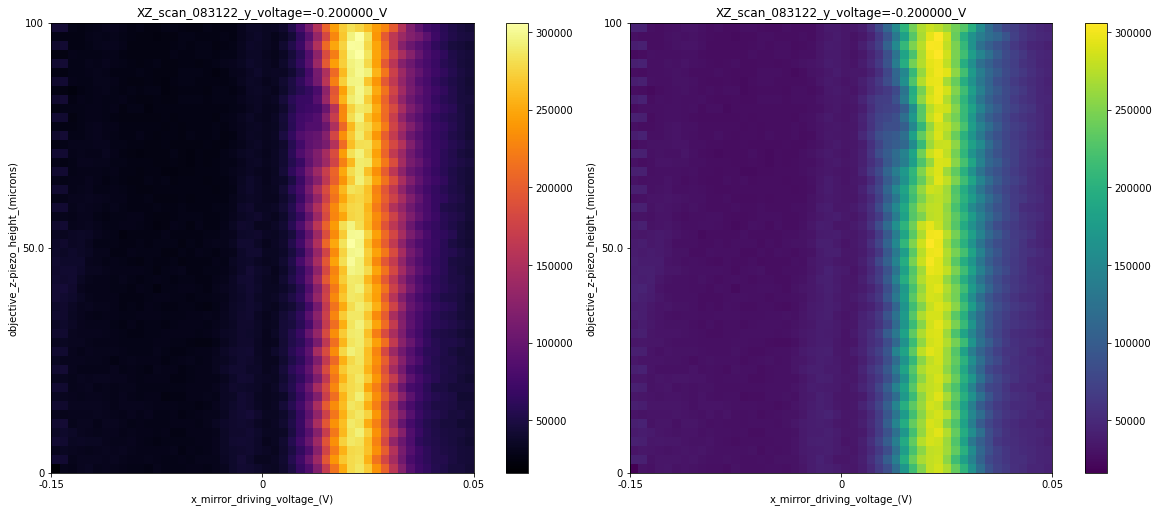

In [92]:
"""
XZ scanning: Fixing y, changing x

last modified/run: 083122

This cell runs a generic X and Y only scan. It currently creates and then populates a user defined size numpy array according to a set counter acquisition time and a motor
step voltage setting. Additionally, the initial driving voltage for the X and Y motors can be set according to the desired scanning range. An adjust factor is in place to
maintain the current scanning window while only adjusting the resolution of the produced data/image. This scan resets the objective's z-piezo to 0.0 microns / 0.0 V. This
setting can be changed if scanning at a different z-height is desired. This scanning program runs in a snake pattern, it scan the first row left to right, moves up one row, 
then scans right to left and continues. Alternatives would be scanning left to right, and resetting the position of the laser on the next higher row and scanning again left 
to right OR scanning in a "circular" patter either CW or CCW from outside to inside or inside to outside. The chosen method was picked for simplicity of understanding. The 
scanning loops are present within NI-DAQmx tasks to speed up the program. Starting and stopping a NI-DAQmx task repeatedly slows down the program dramatically. So, the 
counter and hardware clock task are started once, then the scanning program is run, and then the counter and clock tasks are closed -un-reserving the hardware resources. 
This cell uses the "DAQAnalogOutputs" function from a written class file at:
C:/Users/lukin2dmaterials/miniconda3/envs/qcodes/Lib/site-packages/qcodes_contrib_drivers/drivers/NationalInstruments/class_file. Slashes are reversed to run
"""

# TODO: make this record a QCoDeS measurement
# TODO: grid size here likely should not be required to be square
# TODO: fix printing statements at end of program -specific to xz scanning
# TODO: implement yz scanning?
# TODO: fix plotting scale and add labels
# TODO: allow grid_size_z and grid_size_y to change indep. Currently makes an error if do not match
# TODO: update printed SCANNING INFO

complete_cell_run_time_start = datetime.datetime.now()                                                                               # optional timing line

scan_galvo.close()                                                                                             # note: must be omitted when running for the first time

################################################################################## card 2 (AO) ########################################################################

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables #####################################################################

################### setting variales and array ####################

###################################################### COPY ME TO TO PLOT RESULT #####################################################
# counter read time:
scan_counter_acquisition_time = 0.05                                                                               # note a reading time <0.05 s is likely too short

# def grid_size of scan (resolution)
grid_size = 50

# def the initial driving voltage for the x-mirror
initial_x_driving_voltage = -0.15
# def the initial driving voltage for the y-mirror
initial_y_driving_voltage = -0.2

#
initial_z_piezo_driving_voltage = 0.0

# set desired end mirror voltages
desired_end_x_mirror_voltage = 0.05
desired_end_z_piezo_voltage = 10
###################################################### COPY ME TO TO PLOT RESULT #####################################################

# setup parameter for the program to use based on defined variables
x_driving_voltage_to_change = initial_x_driving_voltage
z_piezo_driving_voltage_to_change = initial_z_piezo_driving_voltage

# def the internal stepping voltages based on user-entered settings above
x_drive_voltage_step = ((np.absolute(initial_x_driving_voltage)) + (desired_end_x_mirror_voltage)) / grid_size
z_piezo_drive_voltage_step = (initial_z_piezo_driving_voltage + (desired_end_z_piezo_voltage)) / grid_size

# create dataset to populate
data_array = np.zeros((grid_size, grid_size))

# initializing variables to store read counter info.
output_value = 0
counter_value = 0

################### resetting position of mirrors ####################

scan_galvo.voltage_cdaq1mod2ao0(initial_x_driving_voltage) # this is for setting the initial x voltage

scan_galvo.voltage_cdaq1mod2ao1(initial_y_driving_voltage) # this is for fixing the x-mirror at defined setting (voltage)

scan_galvo.voltage_cdaq1mod2ao2(initial_z_piezo_driving_voltage) # starting z-piezo at 0.0 V (0 microns); this variable will increase during scanning

########################################################### setting up NI-DAQmx tasks and channels for counting ########################################################

with nidaqmx.Task() as task1, nidaqmx.Task() as counter_output_task: # this defines 2 NI-DAQmx tasks (one for the counter and one for the counter's clock)

    # adding dig pulse train chan
    counter_output_task.co_channels.add_co_pulse_chan_freq(
        counter = "cDAQ1Mod1/ctr1",
        name_to_assign_to_channel = "",
        units = FrequencyUnits.HZ,
        idle_state = nidaqmx.constants.Level.LOW,
        initial_delay = 0.0,
        freq = 1000,
        duty_cycle = 0.5
        )

    # cfg implict timing
    counter_output_task.timing.cfg_implicit_timing(
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )

    # adding count egdes chan
    task1.ci_channels.add_ci_count_edges_chan(
        counter = "cDAQ1Mod1/ctr0",
        name_to_assign_to_channel = "",
        edge = Edge.RISING,
        initial_count = 0,
        count_direction = CountDirection.COUNT_UP
        )

    # cfg sample clk timing
    task1.timing.cfg_samp_clk_timing(
        rate = 1000,
        source = "/cDAQ1/Ctr1InternalOutput",
        active_edge = Edge.RISING,
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )
    
    counter_output_task.start() # this starts the counter NI-DAQmx task
    task1.start() # this starts the hardware-based internal clock NI-DAQmx task
            
####################################################################### x and z scanning #########################################################################

    for f in trange(grid_size, desc = "Scanning progress", initial = 1, colour = "Green"): # this loops for stacks in z

        for k in range(grid_size): # this loops for columns (varying y voltage/setting)

            ################## important section #################

            for my_var_not_named_i in range(int(scan_counter_acquisition_time * 1000)): # this reads/lets the counter accumulate for the set time and returns value
                counter_value = task1.read()
                output_value += counter_value

            if f % 2 != 0: # this loop populates the created data_array (the if else strucuture is present bc of the snaking scanning pattern)
                data_array[f][((-k) + 1)] = (output_value - np.sum(data_array)) # add counter result to data array                           # saving (082422)
                output_value == 0
                counter_value == 0
            else:
                if f == 0 and k == 0:
                    data_array[0][0] = output_value # add counter result to data array                                                      # saving
                else:
                    data_array[f][k] = (output_value - np.sum(data_array)) # add counter result to data array                               # saving (082422)
            output_value = 0
            counter_value = 0

            ############# end important section ############

            if f % 2 == 0: # this loop adjusts for sweeping back and forth along each alternating row
                if k < (grid_size - 1):
                    x_driving_voltage_to_change += x_drive_voltage_step # increment y mirro drive voltage forwards
                    scan_galvo.voltage_cdaq1mod2ao0(x_driving_voltage_to_change) # step y mirror
                else:
                    break
            else:
                if k < (grid_size - 1):
                    x_driving_voltage_to_change -= x_drive_voltage_step # increment y mirror drive voltage backwards
                    scan_galvo.voltage_cdaq1mod2ao0(x_driving_voltage_to_change) # step y mirror
                else:
                    break

        if f < (grid_size - 1): # this loop
            z_piezo_driving_voltage_to_change += z_piezo_drive_voltage_step # increment drive voltage
            scan_galvo.voltage_cdaq1mod2ao2(z_piezo_driving_voltage_to_change) # step z
        else:
            break

    counter_output_task.stop() # this stops the counter NI-DAQmx task - free-ing the reserved cDAQ card resources
    task1.stop() # this stops the hardware-based internal clock NI-DAQmx task - free-ing the reserved cDAQ card resources

################################################################### visualizing scan info. and data #####################################################################

####### printing out scanning and timing info ########
print("SCANNING INFO:")
complete_cell_run_time_end = datetime.datetime.now()                                                                                 # optional timing line
complete_cell_run_time = complete_cell_run_time_end - complete_cell_run_time_start                                                     # optional timing line
print("grid size = %s, " % (grid_size), end = "")
print("counter read time per pixel: %f s, " % scan_counter_acquisition_time, end = "")
print("initial x-mirror driving voltage %f V, end x-mirror driving voltage: %f V, " % (initial_x_driving_voltage, desired_end_x_mirror_voltage), end = "")
print("y-mirror set throughout driving voltage %f V, " % initial_y_driving_voltage, end = "")
print("initial obj z-piezo height %f microns, end obj z-piezo height: %f microns, " % (int(initial_z_piezo_driving_voltage * 10), int(desired_end_z_piezo_voltage * 10)), end = "")
print("complete cell run time (minus printing info. and plotting): %s" % complete_cell_run_time)
# print("\n" + str(data_array))                                                # note the manual data_array must explicitly be saved for user viewing or analysis
# np.save("title_1.npy", data_array)                                                                                  # optional for saving data_array

########## plotting populated data array using MatPlotLib ########
fig, axs = plt.subplots(1, 2, figsize = (16, 7), layout = "constrained")

plot_1 = axs[0].pcolormesh(data_array, cmap = "inferno")
fig.colorbar(plot_1, ax = axs[0])
axs[0].set_xlabel("x_mirror_driving_voltage_(V)")
axs[0].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_x_driving_voltage, int((initial_x_driving_voltage + desired_end_x_mirror_voltage) / 2), desired_end_x_mirror_voltage])
axs[0].set_ylabel("objective_z-piezo_height_(microns)")
axs[0].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [int(initial_z_piezo_driving_voltage * 10), (int(initial_z_piezo_driving_voltage * 10) + int(desired_end_z_piezo_voltage * 10)) / 2, int(desired_end_z_piezo_voltage * 10)])
axs[0].set_title("XZ_scan_083122_y_voltage=%f_V" % initial_y_driving_voltage)

plot_2 = axs[1].pcolormesh(data_array)
fig.colorbar(plot_2, ax = axs[1])
axs[1].set_xlabel("x_mirror_driving_voltage_(V)")
axs[1].set_xticks(np.arange(0, grid_size + 10, grid_size / 2), [initial_x_driving_voltage, int((initial_x_driving_voltage + desired_end_x_mirror_voltage) / 2), desired_end_x_mirror_voltage])
axs[1].set_ylabel("objective_z-piezo_height_(microns)")
axs[1].set_yticks(np.arange(0, grid_size + 10, grid_size / 2), [int(initial_z_piezo_driving_voltage * 10), (int(initial_z_piezo_driving_voltage * 10) + int(desired_end_z_piezo_voltage * 10)) / 2, int(desired_end_z_piezo_voltage * 10)])
axs[1].set_title("XZ_scan_083122_y_voltage=%f_V" % initial_y_driving_voltage);

# plt.savefig("title_2.png", dpi = 3000)                                                                        # optional for saving high-res MPL plot image

In [50]:
np.save("XZ_scan_083022_y_voltage=-0.25_V.npy", data_array)

In [375]:
"""
XY scan QCoDeS meas try_1

last modified/run: 083022
"""

# TODO: make this record a QCoDeS measurement

complete_cell_run_time_start = datetime.datetime.now()                                                                               # optional timing line

scan_galvo.close()                                                                                             # note: must be omitted when running for the first time

################################################################################## card 2 (AO) ########################################################################

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables #####################################################################

################### setting variales and array ###################

# adjust factor (maintains resolution at current scanning window). "0.04" = 1050x1050
adjust_factor = 0.45 # increasing this value speeds up scanning time (2.7 == 15). Using fractional values lengthens scanning time (increasing resolution)

# counter read time:
scan_counter_acquisition_time = 0.05                                                                               # note a reading time <0.05 s is likely too short

# def size of grid to scan (array is square)
grid_size = int(42 / adjust_factor)

# drive voltage step for sweep
drive_voltage_step = adjust_factor * 0.0155

# initial driving voltage for (x and y)
drive_voltage_x = -0.300

# initial driving voltage for y
drive_voltage_y = drive_voltage_x

# create dataset to populate
data_array = np.zeros((grid_size, grid_size))

# initializing variables to store read counter info.
output_value = 0
counter_value = 0

################### setting up QCoDeS measurement #####################

x_and_y_scan_dataset = Measurement(name = "x_and_y_scan_dataset_meas_name", exp = room_temp_NV_exp_control_experiment)
x_and_y_scan_dataset.register_parameter(scan_galvo.voltage_cdaq1mod2ao0)
x_and_y_scan_dataset.register_parameter(scan_galvo.voltage_cdaq1mod2ao1)
# galvo_meas_082422.register_parameter(task1.read, setpoints = (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao1))

################### resetting position of mirrors ####################

scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # this is for the x-mirror

scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y) # this is for the y-mirror

scan_galvo.voltage_cdaq1mod2ao2(9.0) # confirming z-piezo is at 0.0 microns

########################################################### setting up NI-DAQmx tasks and channels for counting ########################################################

with nidaqmx.Task() as task1, nidaqmx.Task() as counter_output_task: # this defines 2 NI-DAQmx tasks (one for the counter and one for the counter's clock)

    # adding dig pulse train chan
    counter_output_task.co_channels.add_co_pulse_chan_freq(
        counter = "cDAQ1Mod1/ctr1",
        name_to_assign_to_channel = "",
        units = FrequencyUnits.HZ,
        idle_state = nidaqmx.constants.Level.LOW,
        initial_delay = 0.0,
        freq = 1000,
        duty_cycle = 0.5
        )

    # cfg implict timing
    counter_output_task.timing.cfg_implicit_timing(
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )

    # adding count egdes chan
    task1.ci_channels.add_ci_count_edges_chan(
        counter = "cDAQ1Mod1/ctr0",
        name_to_assign_to_channel = "",
        edge = Edge.RISING,
        initial_count = 0,
        count_direction = CountDirection.COUNT_UP
        )

    # cfg sample clk timing
    task1.timing.cfg_samp_clk_timing(
        rate = 1000,
        source = "/cDAQ1/Ctr1InternalOutput",
        active_edge = Edge.RISING,
        sample_mode = AcquisitionType.CONTINUOUS,
        samps_per_chan = 1
        )
    
    counter_output_task.start() # this starts the counter NI-DAQmx task
    task1.start() # this starts the hardware-based internal clock NI-DAQmx task
    
    with x_and_y_scan_dataset.run() as datasaver: # this sets up the QCoDeS datasaver in order to save read data as a QCoDeS measurement
        
######################################################################## X and Y scanning #########################################################################

        for f in trange(grid_size, desc = "scanning progress", initial = 1, colour = "Green"): # this loops for rows (y)

            for k in range(grid_size): # this loops for columns (x)

                ################## important section #################

                for my_var_not_named_i in range(int(scan_counter_acquisition_time * 1000)): # this reads/lets the counter accumulate for the set time and returns value
                    counter_value = task1.read()
                    output_value += counter_value

                if f % 2 != 0: # this loop populates the created data_array (the if else strucuture is present bc of the snaking scanning pattern)
                    data_array[f][((-k) + 1)] = (output_value - np.sum(data_array)) # add counter result to data array                           # saving (082422)
                    
                    output_value == 0
                    counter_value == 0
                else:
                    if f == 0 and k == 0:
                        data_array[0][0] = output_value # add counter result to data array                                                      # saving
                    else:
                        data_array[f][k] = (output_value - np.sum(data_array)) # add counter result to data array                               # saving (082422)
                        
                output_value = 0
                counter_value = 0

                datasaver.add_result(
                    (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao0()),
                    (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1())
                    (task1.read, task1.read())
                    )
                
                ############# end important section ############

                if f % 2 == 0: # this loop adjusts for sweeping back and forth along each alternating row
                    if k < (grid_size - 1):
                        drive_voltage_x += drive_voltage_step # increment drive voltage forwards
                        scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                    else:
                        break
                else:
                    if k < (grid_size - 1):
                        drive_voltage_x -= drive_voltage_step # increment drive voltage backwards
                        scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                    else:
                        break

            if f < (grid_size - 1): # this loop prevents from scanning an upper undesired row
                drive_voltage_y += drive_voltage_step # increment drive voltage
                scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y) # step y motor
            else:
                break
        
        x_and_y_scan_dataset_to_plot = datasaver.dataset

    counter_output_task.stop() # this stops the counter NI-DAQmx task - free-ing the reserved cDAQ card resources
    task1.stop() # this stops the hardware-based internal clock NI-DAQmx task - free-ing the reserved cDAQ card resources

################################################################### visualizing scan info. and data #####################################################################

####### printing out scanning and timing info ########
print("SCANNING INFO:")
complete_cell_run_time_end = datetime.datetime.now()                                                                                 # optional timing line
complete_cell_run_time = complete_cell_run_time_end - complete_cell_run_time_start                                                     # optional timing line
print("grid size = %s, " % (grid_size), end = "")
print("counter read time per pixel: %f s, " % scan_counter_acquisition_time, end = "")
print("step voltage %f V, " % drive_voltage_step, end = "")
print("initial driving voltage (origin) %f V" % drive_voltage_x)
print("complete cell run time (except printing info. and plotting): %s" % complete_cell_run_time)
# print("\n" + str(data_array))                                                # note the manual data_array must explicitly be saved for user viewing or analysis
# np.save("title_1.npy", data_array)                                                                                  # optional for saving data_array

########## plotting populated data array using MatPlotLib ########
fig, axs = plt.subplots(1, 2, figsize = (15, 7), layout = "constrained")
plot_1 = axs[0].pcolormesh(data_array)
fig.colorbar(plot_1, ax = axs[0])
plot_2 = axs[1].pcolormesh(data_array, cmap = "RdBu_r")
fig.colorbar(plot_2, ax = axs[1])
axs[0].set_title("scan_082622_normal")
axs[1].set_title("scan_082622_color_other");
# plt.savefig("title_2.png", dpi = 1500)                                                                        # optional for saving MPL plot image

plot_dataset(x_and_y_scan_dataset_to_plot) # QCoDeS dataset plotting function

<>:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13380\2256078987.py:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1())


Starting experimental run with id: 481. 


scanning progress:   0%|          | 0/14 [00:00<?, ?it/s]

An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-0182db87ee5e;
Traceback:
Traceback (most recent call last):
  File "C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13380\2256078987.py", line 150, in <cell line: 80>
    (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1())
TypeError: 'tuple' object is not callable

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13380\2256078987.py:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1())
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13380\2256078987.py:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1())
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_13380\2256078987.py:150: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (scan_galvo.voltage_cdaq1mod2a

TypeError: 'tuple' object is not callable

In [380]:
scan_galvo.voltage_cdaq1mod2ao2(0.0)

Starting experimental run with id: 218. 


z-stack progress:   0%|          | 0/3 [00:00<?, ?it/s]

indiv #0 scanning progress:   0%|          | 0/50 [00:00<?, ?it/s]

indiv #1 scanning progress:   0%|          | 0/50 [00:00<?, ?it/s]

indiv #2 scanning progress:   0%|          | 0/50 [00:00<?, ?it/s]

SCANNING INFO:
grid size = 50, num z scans = 3, counter read time per pixel: 0.050000 s, step voltage 0.012865 V, initial driving voltage (origin) -0.300000 V
complete cell run time (minus printing and plotting): 0:06:15.520673


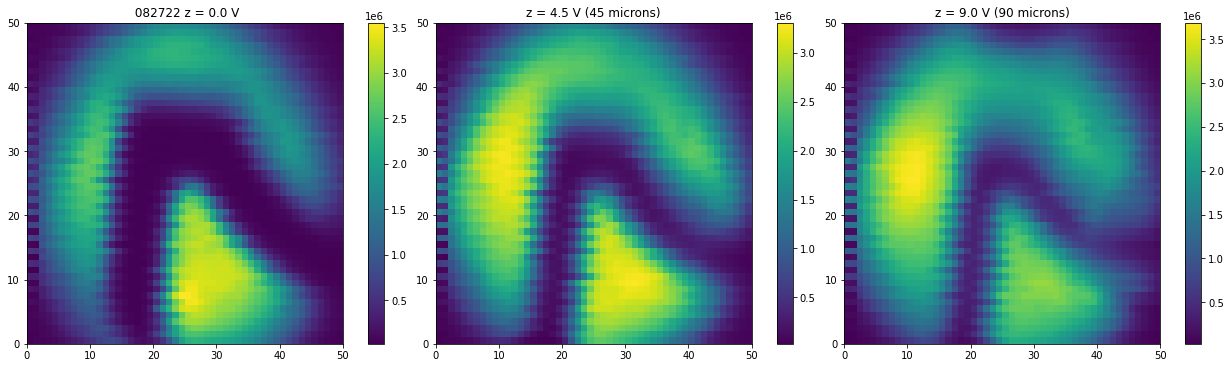

In [412]:
"""
implementing X, Y, and Z scanning with faster speed
This cell runs a generic X, Y, and Z scan. It currently creates and then populates user defined size numpy arrays according to a set counter acquisition time and a motor
step voltage setting. Additionally, the initial driving voltage for the X and Y motors can be set according to the desired scanning range. The initial driving voltage 
for the objective's z-piezo can also be set (currently at 0.0 V to increase per z-stack scan). An adjust factor is in place to
maintain the current scanning window while only adjusting the resolution of the produced data/image. This scan resets the objective's z-piezo to 0.0 microns / 0.0 V. This
setting can be changed if scanning at a different z-height is desired. This scanning program runs in a snake pattern, it scan the first row left to right, moves up one row, 
then scans right to left and continues. Alternatives would be scanning left to right, and resetting the position of the laser on the next higher row and scanning again left 
to right OR scanning in a "circular" patter either CW or CCW from outside to inside or inside to outside. The chosen method was picked for simplicity of understanding. The 
scanning loops are present within NI-DAQmx tasks to speed up the program. Starting and stopping a NI-DAQmx task repeatedly slows down the program dramatically. So, the 
counter and hardware clock task are started once, then the scanning program is run, and then the counter and clock tasks are closed -un-reserving the hardware resources. 
This cell uses the "DAQAnalogOutputs" function from a written class file at:
C:/Users/lukin2dmaterials/miniconda3/envs/qcodes/Lib/site-packages/qcodes_contrib_drivers/drivers/NationalInstruments/class_file. Slashes are reversed to run
"""

# TODO: extend the functionality to work for a different value of num_z_scans (currently @ 3)
# TODO: make this record a QCoDeS measurement
# TODO: fix/add comments above/description
# TODO: alternate colormaps for plotting 3D data?
# TODO: timing for individual z-stack scans (print @ end of program?)

complete_cell_run_time_start = datetime.datetime.now()                                                                               # optional timing line

scan_galvo.close()                                                                                         # note: must be omitted when running for the first time

################################################################################## card 2 (AO) ##########################################################################

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables ####################################################################

################### setting variales and array ####################

# adjust factor (maintains resolution at current scanning window). 0.83 = 50x50
adjust_factor = 0.83 # increasing this value speeds up scanning time (2.7 == 15). Using fractional values lengthens scanning time (increasing resolution)

# counter read time:
scan_counter_acquisition_time = 0.05                                                                               # note a reading time <0.05 s is likely too short

# def size of grid to scan (array is square)
grid_size = int(42 / adjust_factor)

# this defines the number of z-scans to complete
num_z_scans = 3

# create dataset to populate
data_array_1 = np.zeros((grid_size, grid_size))
data_array_2 = np.zeros((grid_size, grid_size))
data_array_3 = np.zeros((grid_size, grid_size))

scan_galvo.voltage_cdaq1mod2ao2(0.0) # starting obj z-piezo at 0.0 microns

# z-piezo driving voltage_step. 0.1 V corresponds to 1.0 microns for the objective z-piezo
z_piezo_drive_voltage_step = 4.5

# initial z-piezo drive voltage
z_piezo_drive_voltage = 0.0 #should be zero? (bc set to this var in resetting parameters section below)

with galvo_meas_082422.run() as datasaver: # this sets up the QCoDeS datasaver in order to save read data as a QCoDeS measurement

    for z_scan_num in trange(num_z_scans, desc = "z-stack progress"): # this loops for the z-stack scans

        counter_value = 0
        counter_value == 0
        output_value = 0
        output_value == 0

        # drive voltage step for sweep
        drive_voltage_step = adjust_factor * 0.0155

        # initial driving voltage for (x and y)
        drive_voltage_x = -0.300

        # initial driving voltage for y
        drive_voltage_y = drive_voltage_x

        ################### setting up QCoDeS measurement #####################

        # galvo_meas_082422 = Measurement(name = "test_name", exp = room_temp_NV_exp_control_experiment)
        # galvo_meas_082422.register_parameter(scan_galvo.voltage_cdaq1mod2ao0)
        # galvo_meas_082422.register_parameter(scan_galvo.voltage_cdaq1mod2ao1)
        # galvo_meas_082422.register_parameter(task1.read, setpoints = (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao1))

        ################### resetting position of mirrors ####################

        scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # this is for the x-mirror

        scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y) # this is for the y-mirror

        ####################################################### setting up NI-DAQmx tasks and channels for counting (note?) ################################################

        # initializing variables to store read counter info.
        output_value = 0
        counter_value = 0

        with nidaqmx.Task() as task1, nidaqmx.Task() as counter_output_task: # this defines 2 NI-DAQmx tasks (one for the counter and one for the counter's clock)

            # adding digital pulse train chan
            counter_output_task.co_channels.add_co_pulse_chan_freq(
                counter = "cDAQ1Mod1/ctr1",
                name_to_assign_to_channel = "",
                units = FrequencyUnits.HZ,
                idle_state = nidaqmx.constants.Level.LOW,
                initial_delay = 0.0,
                freq = 1000,
                duty_cycle = 0.5
                )

            # configure implict clock timing
            counter_output_task.timing.cfg_implicit_timing(
                sample_mode = AcquisitionType.CONTINUOUS,
                samps_per_chan = 1
                )

            # adding count egdes chan
            task1.ci_channels.add_ci_count_edges_chan(
                counter = "cDAQ1Mod1/ctr0",
                name_to_assign_to_channel = "",
                edge = Edge.RISING,
                initial_count = 0,
                count_direction = CountDirection.COUNT_UP
                )

            # configure the hardware sample clk timing
            task1.timing.cfg_samp_clk_timing(
                rate = 1000,
                source = "/cDAQ1/Ctr1InternalOutput",
                active_edge = Edge.RISING,
                sample_mode = AcquisitionType.CONTINUOUS,
                samps_per_chan = 1
                )

            counter_output_task.start() # this starts the counter NI-DAQmx task
            task1.start() # this starts the hardware-based internal clock NI-DAQmx task

            # with galvo_meas_082422.run() as datasaver: # this sets up the QCoDeS datasaver in order to save read data as a QCoDeS measurement

        ###################################################################### X and Y and Z scanning ####################################################################

            for f in trange(grid_size, desc = "indiv #%s scanning progress" % z_scan_num, initial = 1, colour = "Green"): # this loops for rows (y)
                counter_value = 0
                counter_value == 0
                output_value = 0
                output_value == 0

                for k in range(grid_size): # this loops for columns (x)

                    ################## important section (recording data) #################

                    for my_var_not_named_i in range(int(scan_counter_acquisition_time * 1000)): # this reads/lets the counter accumulate for set time and returns value
                        counter_value = task1.read()
                        output_value += counter_value

                    if f % 2 != 0: # this loop populates the created data_array_1 (the if else strucuture is present bc of the snaking scanning pattern)
                        if z_scan_num == 0:
                            data_array_1[f][((-k) + 1)] = (output_value - np.sum(data_array_1)) # add counter result to data array                           # saving
                        elif z_scan_num == 1:
                            data_array_2[f][((-k) + 1)] = (output_value - np.sum(data_array_2)) # add counter result to data array                           # saving
                        elif z_scan_num == 2:
                            data_array_3[f][((-k) + 1)] = (output_value - np.sum(data_array_3)) # add counter result to data array                           # saving
                        output_value == 0
                        counter_value == 0
                    else:
                        if f == 0 and k == 0:
                            if z_scan_num == 0:
                                data_array_1[0][0] = output_value # add counter result to data array                                                      # saving
                            elif z_scan_num == 1:
                                data_array_2[0][0] = output_value # add counter result to data array                                                      # saving
                            elif z_scan_num == 2:
                                data_array_3[0][0] = output_value # add counter result to data array                                                      # saving
                        else:
                            if z_scan_num == 0:
                                data_array_1[f][k] = (output_value - np.sum(data_array_1)) # add counter result to data array                               # saving
                            elif z_scan_num == 1:
                                data_array_2[f][k] = (output_value - np.sum(data_array_2)) # add counter result to data array                               # saving
                            elif z_scan_num == 2:
                                data_array_3[f][k] = (output_value - np.sum(data_array_3)) # add counter result to data array                               # saving
                    output_value = 0
                    counter_value = 0

                    # datasaver.add_result(
                    #     (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao0()),
                    #     (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1()),
                    #     (task1.read, task1.read())
                    #     )

                    ############# end important section (recording data) ############

                    if f % 2 == 0: # this loop adjusts for sweeping back and forth along each alternating row
                        if k < (grid_size - 1):
                            drive_voltage_x += drive_voltage_step # increment drive voltage forwards
                            scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                        else:
                            break
                    else:
                        if k < (grid_size - 1):
                            drive_voltage_x -= drive_voltage_step # increment drive voltage backwards
                            scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                        else:
                            break

                if f < (grid_size - 1): # this loop prevents from scanning an upper-most undesired row
                    drive_voltage_y += drive_voltage_step # increment drive voltage
                    scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y) # step y motor
                else:
                    break

        if z_scan_num == 0 or z_scan_num == 1: # this loop iterates through z-focal planes; stepping the z-piezo
            z_piezo_drive_voltage += z_piezo_drive_voltage_step # step z-piezo driving voltage
            scan_galvo.voltage_cdaq1mod2ao2(z_piezo_drive_voltage) # increase/change z-piezo height
        else:
            break

            counter_output_task.stop() # this stops the counter NI-DAQmx task - free-ing the reserved cDAQ card resources
            task1.stop() # this stops the hardware-based internal clock NI-DAQmx task - free-ing the reserved cDAQ card resources

################################################################### visualizing scan info. and data #####################################################################

####### printing out scanning and timing info ########
print("SCANNING INFO:")
complete_cell_run_time_end = datetime.datetime.now()                                                                                 # optional timing line
complete_cell_run_time = complete_cell_run_time_end - complete_cell_run_time_start                                                     # optional timing line
print("grid size = %s, " % (grid_size), end = "")
print("num z scans = %d, " % num_z_scans, end = "")
print("counter read time per pixel: %f s, " % scan_counter_acquisition_time, end = "")
print("step voltage %f V, " % drive_voltage_step, end = "")
print("initial driving voltage (origin) %f V" % drive_voltage_x)
print("complete cell run time (minus printing and plotting): %s" % complete_cell_run_time)
# print("\ndata_array_1:\n" + str(data_array_1))                                  # note the manual data_array_1 must explicitly be saved for user viewing or analysis
# print("\ndata_array_2:\n" + str(data_array_2))                                  # note the manual data_array_2 must explicitly be saved for user viewing or analysis
# print("\ndata_array_3:\n" + str(data_array_3))                                  # note the manual data_array_3 must explicitly be saved for user viewing or analysis

np.save("082722_data_array_1_646x646_0_microns.npy", data_array_1)                                                                                     # optional for saving data_array_1
np.save("082722_data_array_2_646x646_45_microns.npy", data_array_2)                                                                                     # optional for saving data_array_2
np.save("082722_data_array_3_646x646_90_microns.npy", data_array_3)                                                                                     # optional for saving data_array_3

########## plotting populated data arrays using MatPlotLib ########
fig, axs = plt.subplots(1, 3, figsize = (17, 5), layout = "constrained")

plot_1 = axs[0].pcolormesh(data_array_1) # plotting data_array_1
fig.colorbar(plot_1, ax = axs[0])
axs[0].set_title(" 082722 z = 0.0 V")

plot_2 = axs[1].pcolormesh(data_array_2) # plotting data_array_2
fig.colorbar(plot_2, ax = axs[1])
axs[1].set_title("z = 4.5 V (45 microns)")

plot_3 = axs[2].pcolormesh(data_array_3) # plotting data_array_3
fig.colorbar(plot_3, ax = axs[2])
axs[2].set_title("z = 9.0 V (90 microns)");
# plt.savefig("082522_XYZ_scan2_0_30_60_microns.png", dpi = 1500)                                                                   # optional for saving MPL plotted image

scan_galvo.voltage_cdaq1mod2ao2(0.0) # return obj z-piezo to 0 V

In [411]:
np.save("Y_diamond_on_stripline_082722_demo_DA_1_650x650.npy", data_array_1)                                                                                     # optional for saving data_array_1
np.save("Y_diamond_on_stripline_082722_demo_DA_2_650x650.npy", data_array_2)                                                                                     # optional for saving data_array_2
np.save("Y_diamond_on_stripline_082722_demo_DA_3_650x650.npy", data_array_3)                                                                                     # optional for saving data_array_3

In [165]:
np.save("082422_faster_scan_03.npy", data_array)

Starting experimental run with id: 479. 


  0%|          | 0/12 [00:00<?, ?it/s]

scanning info:

total scanning time: 0:00:34.784621
counter acquisition time: 0.003 s
grid_size = 12


C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\dataset\data_export.py:143: RuntimeWarning: divide by zero encountered in divide
  remainders = np.mod(steps[1:]/steps[0], 1)
C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\lib\site-packages\qcodes\dataset\data_export.py:143: RuntimeWarning: invalid value encountered in remainder
  remainders = np.mod(steps[1:]/steps[0], 1)


([<AxesSubplot:title={'center':'Run #479, Experiment room_temp_NV_exp_control_experiment (room_temp_NV_exp_control_experiment_data)'}, xlabel='Voltage (mV)', ylabel='Voltage (mV)'>],
 [<matplotlib.colorbar.Colorbar at 0x1b41c2c0ac0>])

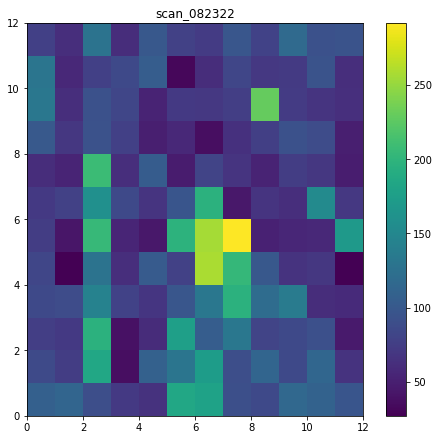

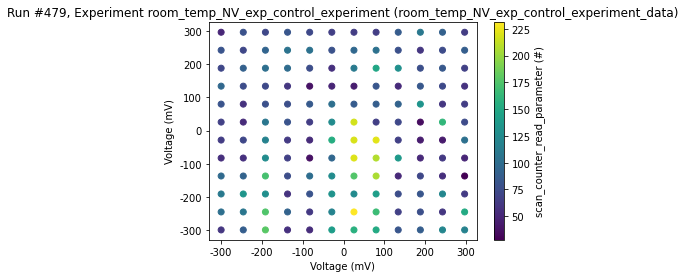

In [333]:
# what this is; scanning. started 081922
# X and Y scanning. No Z. Plots both manually from created data array and QCoDeS plotting (when run, data is saved as QCoDeS measurement)
# note: maintaining ratio btw grid_size and drive_voltae_step ensures only the resoulution of the scanned image changes, not the scanning window itself
# note: this cell uses functions written in "class_file"
#@ "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\Lib\site-packages\qcodes_contrib_drivers\drivers\NationalInstruments\class_file"

# close instruments
scan_counter.close()
scan_galvo.close()

#################################################################################### card 1 ############################################################################

read_acquisition_time = 0.003

scan_counter = Scan_Counter(
    "name_for_inst",
    scan_counter_device_name = "cDAQ1Mod1",
    scan_counter_counter_channel = "cDAQ1Mod1/ctr0",
    scan_counter_clock_channel = "cDAQ1Mod1/ctr1",
    scan_counter_source_channel = "/cDAQ1/Ctr1InternalOutput",
    scan_counter_sampling_rate = 1000,
    scan_counter_samples_per_channel = 1,
    scan_counter_duty_cycle = 0.5,
    scan_counter_acquisition_time = read_acquisition_time # this is in seconds. As long as sampling_rate is 1000. If not, math must change for acquisition time
    )

##################################################################################### card 2 ###########################################################################

# notes: need counter; needs req. parameters

# naming the instrument
scan_galvo_card_name = "cDAQ1Mod2"

# dictionary of analog output channels
scan_galvo_ao_channels = {f'{scan_galvo_card_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
scan_galvo = DAQAnalogOutputs("name_two", scan_galvo_card_name, scan_galvo_ao_channels)

############################################################################### def other variables #####################################################################

#################### setting variales and array ####################

# adjust factor (maintains resolution at current scanning window)
adjust_factor = 3.5

# def size of grid to scan (array is square)
grid_size = int(42 / adjust_factor)

# drive voltage step for sweep
drive_voltage_step = adjust_factor * 0.0155

# initial driving voltage for (x and y)
drive_voltage_x = -0.300

# initial driving voltage for y
drive_voltage_y = drive_voltage_x

# create dataset to populate
data_array = np.zeros((grid_size, grid_size))

############################################################################################ scanning ##################################################################

################### resetting position of mirrors ####################

# x-mirror
scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x)

# y-mirror
scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y)

################ setting up QCoDeS measurement #######################

galvo_meas_3 = Measurement(name= "082322_scan", exp = room_temp_NV_exp_control_experiment)

galvo_meas_3.register_parameter(scan_galvo.voltage_cdaq1mod2ao0)
galvo_meas_3.register_parameter(scan_galvo.voltage_cdaq1mod2ao1)
galvo_meas_3.register_parameter(scan_counter.Scan_Counter_Read, setpoints = (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao1))

################ looping over grid (scanning) ############################

# print(data_array)

start_time = datetime.datetime.now()

with galvo_meas_3.run() as datasaver:
    
    for i in trange(grid_size): #
        # print("i = %d" % i)
        
        # i_timing_start = datetime.datetime.now()                                                        # timing line
        
        for k in range(grid_size): #
            # k_timing_start = datetime.datetime.now()                                                                    # timing line
            # print("k = %d" % k)
            
            result = scan_counter.Scan_Counter_Read() # read counter (w/ delay)
            if i % 2 != 0:
                data_array[i][-(k + 1)] = result # add counter result to data array
            else:
                data_array[i][k] = result # add counter result to data array
            
            datasaver.add_result(
                (scan_galvo.voltage_cdaq1mod2ao0, scan_galvo.voltage_cdaq1mod2ao0()),
                (scan_galvo.voltage_cdaq1mod2ao1, scan_galvo.voltage_cdaq1mod2ao1()),
                (scan_counter.Scan_Counter_Read, scan_counter.Scan_Counter_Read())
                )
            
            if i % 2 == 0: # if i is 0 or even
                if k < (grid_size - 1):
                    drive_voltage_x += drive_voltage_step # increment drive voltage
                    scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                else:
                    break
            else:
                if k < (grid_size - 1):
                    drive_voltage_x -= drive_voltage_step # increment drive voltage
                    scan_galvo.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                else:
                    break
            
            # k_timing_end = datetime.datetime.now()                                                                    # timing line
            # print("k loop timing: %s" % (k_timing_end - k_timing_start))                                              # timing line
            
        # print("end of k loop")
        if i < (grid_size - 1):
            drive_voltage_y += drive_voltage_step # increment drive voltage
            scan_galvo.voltage_cdaq1mod2ao1(drive_voltage_y) # step y motor
        else:
            break
        
        # i_timing_end = datetime.datetime.now()                                                            # timing line
        # print("i loop timing: %s" % (i_timing_end - i_timing_start))                                              # timing line
        # print("end of i loop")

    dataset_galvo_meas_3 = datasaver.dataset

end_time = datetime.datetime.now()

##################################################################### visualizing scan data ############################################################################

scanning_time = end_time - start_time
print("scanning info:\n")
print("total scanning time: %s" % scanning_time)
print("counter acquisition time: %s s" % read_acquisition_time)
print("grid_size = %s" % (grid_size))

# print(data_array)

fig, axs = plt.subplots(figsize = (6, 6), layout = "constrained")
plot1 = axs.pcolormesh(data_array)
fig.colorbar(plot1, ax = axs)
axs.set_title("scan_082322");

plot_dataset(dataset_galvo_meas_3) # QCoDeS plotting

In [336]:
np.save("082222_file_19", data_array)

z-stack progress:   0%|          | 0/3 [00:00<?, ?it/s]

indiv. scans progress:   0%|          | 0/345 [00:00<?, ?it/s]

before step; z-piezo voltage = 0.0 
after step; z-piezo voltage = 0.5 
z scan # 1/3 complete


indiv. scans progress:   0%|          | 0/345 [00:00<?, ?it/s]

before step; z-piezo voltage = 0.5 
after step; z-piezo voltage = 1.0 
z scan # 2/3 complete


indiv. scans progress:   0%|          | 0/345 [00:00<?, ?it/s]

scanning time: 13:15:30.285194


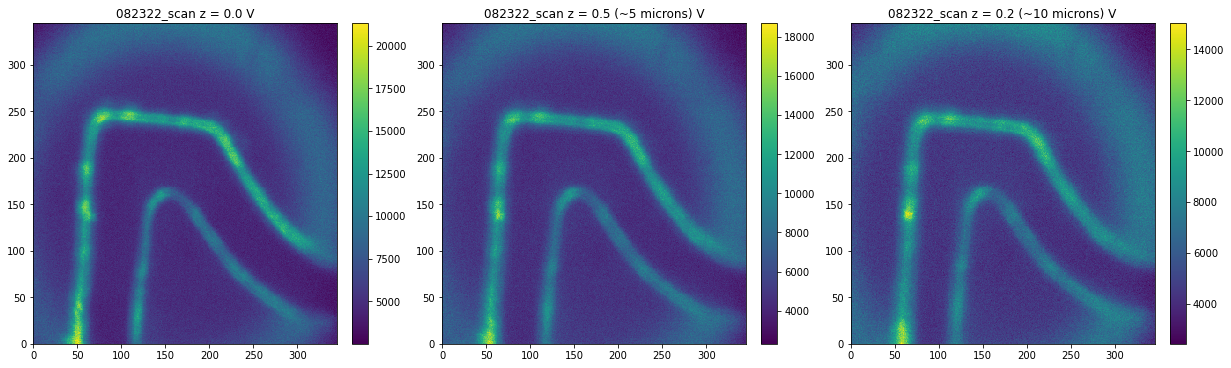

In [34]:
"""
083022 this is OLD
"""

# what this is; scanning. started 082322
# X, Y, and Z scanning
# note: this cell uses functions written in "class_file"
#@ "C:\Users\lukin2dmaterials\miniconda3\envs\qcodes\Lib\site-packages\qcodes_contrib_drivers\drivers\NationalInstruments\class_file"

# close instruments
scan_counter.close()
threeD_scan_inst.close()

############################################################# initializing counter input instrument on NI card 1 ########################################################

scan_counter = Scan_Counter(
    "name_fohjgfbdr_inst",
    scan_counter_device_name = "cDAQ1Mod1",
    scan_counter_counter_channel = "cDAQ1Mod1/ctr0",
    scan_counter_clock_channel = "cDAQ1Mod1/ctr1",
    scan_counter_source_channel = "/cDAQ1/Ctr1InternalOutput",
    scan_counter_sampling_rate = 1000,
    scan_counter_samples_per_channel = 1,
    scan_counter_duty_cycle = 0.5,
    scan_counter_acquisition_time = 0.03 # this is in seconds. As long as sampling_rate is 1000. If not, math must change for acquisition time
    )

############################################################## initializing analog output instrument on NI card 2 #######################################################

# notes: need counter; needs req. parameters

# naming the instrument
threeD_scan_card_ni_9263_name = "cDAQ1Mod2"

# dictionary of analog output channels
threeD_scan_card_ni_9263_ao_channels = {f'{threeD_scan_card_ni_9263_name}/ao{i}': i for i in range(4)}

# defining the instrument (ni_9263)
threeD_scan_inst = DAQAnalogOutputs("threeD_scanmjfgb_card_ni_9263_name_two", threeD_scan_card_ni_9263_name, threeD_scan_card_ni_9263_ao_channels)

############################################################################### def other variables #####################################################################

#################### setting variales and array ###################

# factor to adjust resolution at set scanning window
adjust_factor = 1

# def size of grid to scan (array is square)
grid_size = int(int(46 / adjust_factor)*7.5)

# setting number of z-scans to read
num_z_scans = 3

# initial z-piezo drive voltage
z_piezo_drive_voltage = 0.0 #should be zero? (bc set to this var in resetting parameters section below)

# z-piezo driving voltage_step. 0.1 V corresponds to 1.0 microns for the objective z-piezo
z_piezo_drive_voltage_step = 0.5

# drive voltage step for sweep
drive_voltage_step = (adjust_factor * 0.0155) / 7.5

# initial driving voltage for (x and y)
drive_voltage_x = -0.300

# initial driving voltage for y
drive_voltage_y = drive_voltage_x

# create datasets to populate
# there are multiple for z-depth scanning
data_array_1 = np.zeros((grid_size, grid_size))
data_array_2 = np.zeros((grid_size, grid_size))
data_array_3 = np.zeros((grid_size, grid_size))

############################################################################################ scanning ##################################################################

################### resetting position of mirrors ####################

# x-mirror
threeD_scan_inst.voltage_cdaq1mod2ao0(drive_voltage_x)

# y-mirror
threeD_scan_inst.voltage_cdaq1mod2ao1(drive_voltage_y)

############### resetting position of objective Z-piezo ################

threeD_scan_inst.voltage_cdaq1mod2ao2(z_piezo_drive_voltage) # sets z-piezo height to 0 V

################ setting up QCoDeS measurement #######################

galvo_meas_3 = Measurement(name= "082322_scan", exp = room_temp_NV_exp_control_experiment)

galvo_meas_3.register_parameter(threeD_scan_inst.voltage_cdaq1mod2ao0)
galvo_meas_3.register_parameter(threeD_scan_inst.voltage_cdaq1mod2ao1)
galvo_meas_3.register_parameter(scan_counter.Scan_Counter_Read, setpoints = (threeD_scan_inst.voltage_cdaq1mod2ao0, threeD_scan_inst.voltage_cdaq1mod2ao1))

################ looping over grid (scanning) ############################

# print(data_array_1, data_array_2, data_array_3, end = " ") # test line to comment out for checking

start_time = datetime.datetime.now()

# with galvo_meas_3.run() as datasaver:                                                                                   # omit now

# loop for z-scans
for a in trange(num_z_scans, desc = "z-stack progress"):
    
    ############ resets (excluding z-piezo) for each scan w/in the z-stack #############

    drive_voltage_x = -0.300 # initial driving voltage for (x and y)

    drive_voltage_y = drive_voltage_x # initial driving voltage for y
    
    threeD_scan_inst.voltage_cdaq1mod2ao0(drive_voltage_x) # x-mirror

    threeD_scan_inst.voltage_cdaq1mod2ao1(drive_voltage_y) # y-mirror

    for i in trange(grid_size, desc = "indiv. scans progress"): #
        # print("i = %d" % i)

        for k in range(grid_size): #
            # print("k = %d" % k)

            result = scan_counter.Scan_Counter_Read() # read counter (w/ delay)
            if i % 2 != 0:
                if a == 0:
                    data_array_1[i][-(k + 1)] = result # add counter result to data array
                elif a == 1:
                    data_array_2[i][-(k + 1)] = result # add counter result to data array
                elif a == 2:
                    data_array_3[i][-(k + 1)] = result # add counter result to data array
            else:
                if a == 0:
                    data_array_1[i][k] = result # add counter result to data array
                elif a == 1:
                    data_array_2[i][k] = result # add counter result to data array
                elif a == 2:
                    data_array_3[i][k] = result # add counter result to data array

            # datasaver.add_result(                                                                                       # omit now
            #     (threeD_scan_inst.voltage_cdaq1mod2ao0, threeD_scan_inst.voltage_cdaq1mod2ao0()),
            #     (threeD_scan_inst.voltage_cdaq1mod2ao1, threeD_scan_inst.voltage_cdaq1mod2ao1()),
            #     (scan_counter.Scan_Counter_Read, scan_counter.Scan_Counter_Read())
            #     )

            if i % 2 == 0: # if i is 0 or even
                if k < (grid_size - 1):
                    drive_voltage_x += drive_voltage_step # increment drive voltage
                    threeD_scan_inst.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                else:
                    break
            else:
                if k < (grid_size - 1):
                    drive_voltage_x -= drive_voltage_step # increment drive voltage
                    threeD_scan_inst.voltage_cdaq1mod2ao0(drive_voltage_x) # step x motor
                else:
                    break

        # print("end of k loop")
        if i < (grid_size - 1):
            drive_voltage_y += drive_voltage_step # increment drive voltage
            threeD_scan_inst.voltage_cdaq1mod2ao1(drive_voltage_y) # step y motor
        else:
            break
        # print("end of i loop")
    
    if a == 0 or a == 1:
        print("before step; z-piezo voltage = %s " % z_piezo_drive_voltage)
        z_piezo_drive_voltage += z_piezo_drive_voltage_step # step z-piezo driving voltage
        threeD_scan_inst.voltage_cdaq1mod2ao2(z_piezo_drive_voltage) # increase/change z-piezo height
        print("after step; z-piezo voltage = %s " % z_piezo_drive_voltage)
        print("z scan # %d/%d complete" % ((a + 1), (num_z_scans)))
    else:
        break

    # dataset_galvo_meas_3 = datasaver.dataset                                                                         # omit now

end_time = datetime.datetime.now()

##################################################################### visualizing scan data ############################################################################

scanning_time = end_time - start_time
print("scanning time: %s" % scanning_time)

# print(data_array_1, "\n\n", data_array_2, "\n\n", data_array_3, end = " ") # test line to comment out for checking

fig, axs = plt.subplots(1, 3, figsize = (17, 5), layout = "constrained")

plot_1 = axs[0].pcolormesh(data_array_1)
fig.colorbar(plot_1, ax = axs[0])
axs[0].set_title("082322_scan z = 0.0 V");

plot_2 = axs[1].pcolormesh(data_array_2)
fig.colorbar(plot_2, ax = axs[1])
axs[1].set_title("082322_scan z = 0.5 (~5 microns) V");

plot_3 = axs[2].pcolormesh(data_array_3)
fig.colorbar(plot_3, ax = axs[2])
axs[2].set_title("082322_scan z = 0.2 (~10 microns) V");

# plot_dataset(dataset_galvo_meas_3) # QCoDeS plotting                                                                         # omit now

In [37]:
np.save("data_082422_10", data_array_3)

In [215]:
my_dataset = dataset_galvo_meas_3.get_parameter_data()

# print(my_dataset)

# print("\n")

# print(my_dataset["name_for_inst_Scan_Counter_Read"])

# print("\n")

print(my_dataset["name_for_inst_Scan_Counter_Read"]["name_for_inst_Scan_Counter_Read"])
my_counter_values = my_dataset["name_for_inst_Scan_Counter_Read"]["name_for_inst_Scan_Counter_Read"]

print("\n")

print(my_dataset["name_for_inst_Scan_Counter_Read"]["name_two_voltage_cdaq1mod2ao0"])
my_x_values = my_dataset["name_for_inst_Scan_Counter_Read"]["name_two_voltage_cdaq1mod2ao0"]

print("\n")

print(my_dataset["name_for_inst_Scan_Counter_Read"]["name_two_voltage_cdaq1mod2ao1"])
my_y_values = my_dataset["name_for_inst_Scan_Counter_Read"]["name_two_voltage_cdaq1mod2ao1"]

[191072. 215542. 230054. 260847. 282138. 332928. 359334. 373966. 366507.
 409553. 468205. 470773. 458824. 405342. 376409. 395023. 446376. 473705.
 493735. 465331. 441536. 412780. 406209. 384186. 349140. 291426. 259900.
 232362. 204859. 186003. 182777. 211827. 232294. 275764. 305113. 341402.
 391041. 422575. 440574. 447894. 472175. 487309. 491160. 490417. 401245.
 418032. 482558. 503375. 491417. 486754. 469497. 452084. 430236. 410641.
 364271. 329333. 268636. 225322. 213477. 179503. 176976. 205203. 216739.
 243814. 314926. 355427. 421034. 447152. 432559. 463167. 500146. 502732.
 517954. 488456. 428434. 426205. 494354. 517671. 501792. 527772. 473407.
 420772. 443117. 405140. 335501. 292230. 235860. 219535. 201625. 172938.
 173126. 193797. 206209. 237955. 276460. 333676. 408932. 443529. 422216.
 466356. 521388. 514668. 520296. 511044. 438434. 417790. 497459. 516032.
 498619. 471058. 451168. 416700. 437276. 404670. 337592. 272836. 234212.
 216747. 190660. 179504. 169037. 179295. 207634. 21

#### 1. Galvo scan: using the galvo in the confocal microscope (Measurement)

Text here

Notes:
1. Move the two check cells somehwere? or group them?
2. Worked @ meas ID #111

In [304]:
# reset galvo (to 0 V) cell

# x-mirror
ni_9263.voltage_cdaq1mod2ao0(0)

# y-mirror
ni_9263.voltage_cdaq1mod2ao1(0)

In [ ]:
# galvo check cell:

for i in range(30):
    ni_9263.voltage_cdaq1mod2ao0(10), ni_9263.voltage_cdaq1mod2ao1(10)
    sleep(1)
    ni_9263.voltage_cdaq1mod2ao0(0), ni_9263.voltage_cdaq1mod2ao1(0)
    sleep(1)

Starting experimental run with id: 227. 


counter read progress:   0%|          | 0/100 [00:00<?, ?it/s]

([<AxesSubplot:title={'center':'Run #227, Experiment room_temp_NV_exp_control_experiment (room_temp_NV_exp_control_experiment_data)'}, xlabel='Elapsed time (s)', ylabel='Counter (#)'>],
 [None])

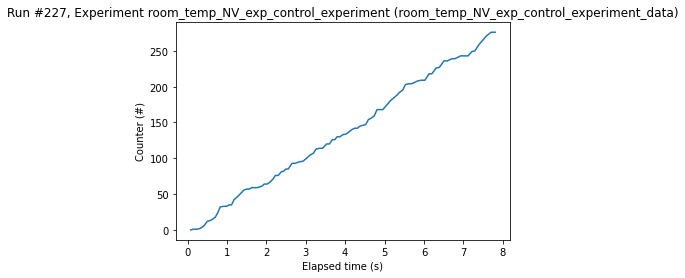

In [427]:
# setup pre-parameters for the finite measurement
counter_value_to_read = ni_9402.read_counter_cdaq1mod1ctr0
time = ElapsedTimeParameter("time")

# user-defined variable for the measurement
num_counter_values_to_read = 100

# setup the measurement
counter_finite_samples_meas = Measurement(
    exp = room_temp_NV_exp_control_experiment,
    station = room_temp_NV_exp_control_station,
    name = "name_3"
    )

# registering defined parameters to the measurement (counter_finite_samples_meas)
counter_finite_samples_meas.register_parameter(time)
counter_finite_samples_meas.register_parameter(counter_values, setpoints = [time])

# loop to read finite number of values from counter
with counter_finite_samples_meas.run() as datasaver:
    
    # before loop statements
    counter_values_list = 0
    time.reset_clock()
    
    # measurement loop
    for i in trange(num_counter_values_to_read, desc = "counter read progress"): # use tqdm for progress bar
        counter_values_list += counter_value_to_read()
        current_time = time()
        datasaver.add_result((counter_value_to_read, counter_values_list), (time, current_time))

# save to user-defined/named dataset for later viewing
three = datasaver.dataset

# temp line DELETE later
plot_dataset(three)

BREAK

In [398]:
Plot_by_id(214)

NameError: name 'Plot_by_id' is not defined

In [396]:
#

# export to csv
# dataset_galvo_meas_2.export("csv", path=".")
a = Load_by_id(run_id = 214)
# dataset_galvo_meas_2_id_127 = load_by_run_spec(experiment_name = room_temp_NV_exp_control_experiment, captured_run_id = 214)

NameError: name 'Load_by_id' is not defined

## Analysis

___

This section is where the data obtained from above measurements is carried out. The numbering scheme below should correspond to the different numbered measurements above.

In [251]:
experiments_widget(sort_by = "timestamp")

### Reading from the chosen counter channel (Analysis)

Basic analysis for two counter measurements.

#### 1. Reading a single sample from the chosen counter channel (Analysis)

This section will return the single read result measurements from the counter.

TODO: accesing the single value from the "experimental run id #" -instead of printing a value defined w/in the actual measurement

In [87]:
# displaying the single result from the counter
print("counter value = %s" % str(result_test))

counter value = 0.0


#### 2. Reading a finite number of smaples from the chosen counter channel (Analysis)

This section will return the results of measurements that acquired a finite number of samples from the counter.

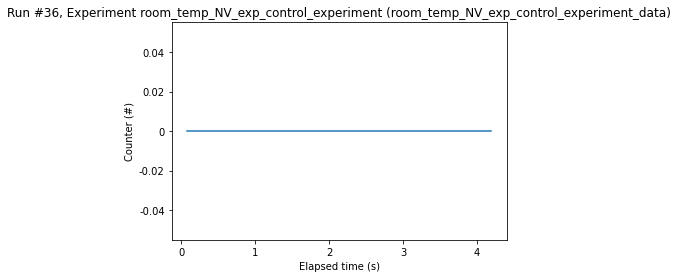

In [93]:
# using the QCoDeS internal plotting functionality (`plot_dataset`) to visualize the measurement caried out in an above cell
axs, cbs = plot_dataset(counter_finite_samples_dataset)

# TODO: additional plotting parameters? Plot window size?
# TODO: add a comment or note somewhere about the automatic plot labeling according to the measurement (the measurement parameters)

### Galvo scanning (Analysis)

Analysis section for galvo scanning measurements.

#### 1. Galvo scan generic(?) (Analysis)

In [100]:
print("fill in")

fill in
